In [ ]:
!pip install nilearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 25.3 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf

# Check if GPU is available
device_name = tf.test.gpu_device_name()
if device_name:
    print(f"GPU is active: {device_name}")
else:
    print("No GPU detected")


GPU is active: /device:GPU:0


In [ ]:
# Import Nilearn library
from nilearn import datasets
import nilearn.datasets
from nilearn.datasets import fetch_oasis_vbm
from nilearn.image import load_img

In [ ]:
# Import necessary libraries
from nilearn.datasets import fetch_oasis_vbm
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import pandas as pd
from nilearn.maskers import NiftiMasker
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import seaborn as sns
from sklearn.impute import SimpleImputer

**Pre-trained DenseNet+SVM**

In [ ]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 11.7 MB/s eta 0:00:00


In [ ]:
import random
import tensorflow as tf
import numpy as np
import os
os.environ['PYTHONHASHSEED'] = '42'
os.environ['TF_DETERMINISTIC_OPS']= '1'
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)
tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

In [ ]:
# Import libraries
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
import optuna
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

**Pre-Processing**

In [ ]:
# Device Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Load Oasis-1 Dataset
dataset = fetch_oasis_vbm(n_subjects=403)
images = dataset.gray_matter_maps
labels = np.where(dataset.ext_vars['cdr'].astype(float) > 0, 1, 0)  # 1: Demented, 0: Non-demented

# Initial Split (before Standardization)
images_trainval, images_test, y_trainval, y_test = train_test_split(images, labels, test_size=0.2, random_state=42, stratify=labels)

images_train, images_val, y_train, y_val = train_test_split(images_trainval, y_trainval, test_size=0.2, random_state=42, stratify=y_trainval)

In [ ]:
# Load Images as Flattened Vectors
def load_flattened_images(image_paths):
    data = []
    for path in tqdm(image_paths):
        img = nib.load(path).get_fdata().astype(np.float32)
        data.append(img.flatten())
    return np.array(data)

X_train_flat = load_flattened_images(images_train)
X_val_flat = load_flattened_images(images_val)
X_test_flat = load_flattened_images(images_test)

# Perform Z-Score Normalization Using StandardScaler
scaler = StandardScaler()
X_train_flat = scaler.fit_transform(X_train_flat)
X_val_flat = scaler.transform(X_val_flat)
X_test_flat = scaler.transform(X_test_flat)


Using device: cpu


[get_dataset_dir] Dataset found in /root/nilearn_data/oasis1

100%|██████████| 81/81 [00:02<00:00, 33.78it/s]


In [ ]:
# Reshape back the images to 3D and build Torch Dataset
class OASISDataset(Dataset):
    def __init__(self, flat_data, labels, original_shape=(91, 109, 91)):
        self.flat_data = flat_data
        self.labels = labels
        self.original_shape = original_shape

    def __len__(self):
        return len(self.flat_data)

    def __getitem__(self, idx):
        img = self.flat_data[idx].reshape(self.original_shape)
        img_tensor = torch.tensor(img).unsqueeze(0)  # shape: (1, 91, 109, 91)
        return img_tensor, self.labels[idx]

train_dataset = OASISDataset(X_train_flat, y_train)
val_dataset = OASISDataset(X_val_flat, y_val)
test_dataset = OASISDataset(X_test_flat, y_test)


In [ ]:
# The pre-trained BrainAge_DenseNet is retrived from Hugging Face https://huggingface.co/SisInfLab-AIBio/BrainAge_DenseNet
# Reference paper: De Bonis, M. L. N., Fasano, G., Lombardi, A., Ardito, C., Ferrara, A., Di Sciascio, E., & Di Noia, T. (2024). Explainable brain
# age prediction: a comparative evaluation of morphometric and deep learning pipelines. Brain Informatics, 11(1), 33.

In [ ]:
# The SVM hyperparamters are retrieved from this paper: Givian, H., Calbimonte, J. P., & for the Alzheimer’s Disease Neuroimaging Initiative (2024)
# Early diagnosis of Alzheimer’s disease and mild cognitive impairment using MRI analysis and machine learning algorithms. Discover Applied Sciences, 7(1), 27.

In [ ]:
# Load Pre-trained BrainAge DenseNet and prepare the feature extractor
from densenet import load_preTrained_DenseNet
model_path = "/content/drive/MyDrive/brainage_densenet/DenseNet_params.pt"
full_model = load_preTrained_DenseNet(device=device, path=model_path).to(device)
full_model.eval()

for param in full_model.parameters():
    param.requires_grad = False

feature_extractor = torch.nn.Sequential(*list(full_model.children())[:-1]).to(device)

# Extract Features
def extract_features(model, dataset, batch_size=4):
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    features = []
    model.eval()
    with torch.no_grad():
        for x, _ in tqdm(loader):
            x = x.to(device)
            out = model(x).view(x.size(0), -1)
            features.append(out.cpu().numpy())
    return np.vstack(features)

X_train = extract_features(feature_extractor, train_dataset)
X_val = extract_features(feature_extractor, val_dataset)
X_test = extract_features(feature_extractor, test_dataset)

100%|██████████| 21/21 [01:17<00:00,  3.69s/it]


In [ ]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Define the Optuna Objective function and the hyperparameters

def objective(trial):
    kernel = trial.suggest_categorical("kernel", ["linear", "rbf", "poly", "sigmoid"])
    C = trial.suggest_categorical("C", [0.01, 0.1, 1, 10, 100, 1000])
    gamma = trial.suggest_categorical("gamma", [1e-4, 1e-3, 1e-2, 0.1, 1, 10])
    # Configure SVM based on kernel
    if kernel == "linear":
        model = SVC(C=C, kernel=kernel, probability=True)
    else:
        model = SVC(C=C, kernel=kernel, gamma=gamma, probability=True)

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=skf, scoring='accuracy')
    return scores.mean()


In [ ]:
import optuna
import logging

# Suppress Optuna INFO and DEBUG logs
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Run the optimization
study_densenetsvm = optuna.create_study(direction="maximize")
study_densenetsvm.optimize(objective, n_trials=30)
print("Best SVM Params:", study_densenetsvm.best_params)

Best SVM Params: {'kernel': 'linear', 'C': 100, 'gamma': 0.01}


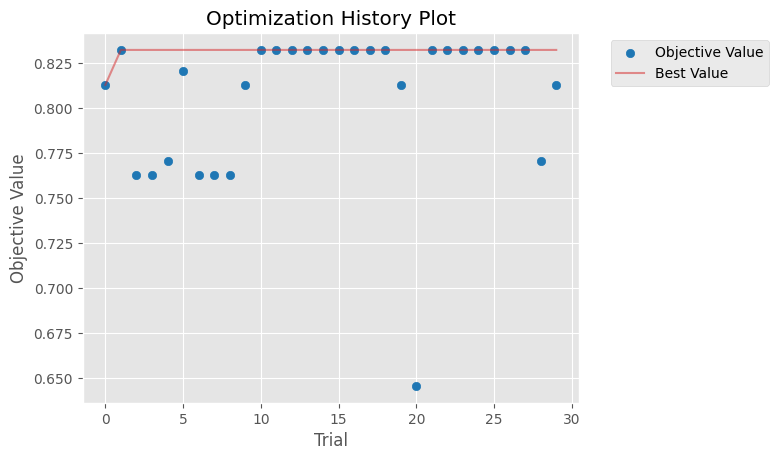

In [ ]:
import warnings
import optuna.visualization.matplotlib as vis_matplotlib

# Suppress warning and plot the optimization history
with warnings.catch_warnings():
    warnings.simplefilter("ignore", optuna.exceptions.ExperimentalWarning)
    ax = vis_matplotlib.plot_optimization_history(study_densenetsvm)

# Save the figure
fig = ax.figure
fig.savefig("optuna_optimization_history_densenetsvm.png", dpi=300, bbox_inches='tight')


In [ ]:
densenetsvm_params = study_densenetsvm.best_params
print(densenetsvm_params)

{'kernel': 'linear', 'C': 100, 'gamma': 0.01}


In [ ]:
final_params_densenetsvm = dict(kernel=densenetsvm_params['kernel'], C= densenetsvm_params['C'], gamma = densenetsvm_params['gamma'])

In [ ]:
# Combine train and val sets
X_trainval = np.concatenate([X_train_flat, X_val_flat], axis=0)
y_trainval = np.concatenate([y_train, y_val], axis=0)

# Define the final SVM with best hyperparameters
model = SVC(kernel='linear', C=100, gamma=0.01, probability=True)

# Train the algorithm on combined train+val set
model.fit(X_trainval, y_trainval)


SVC(C=100, gamma=0.01, kernel='linear', probability=True)

In [ ]:
from sklearn.metrics import (accuracy_score, balanced_accuracy_score, precision_score,
                             recall_score, f1_score, log_loss, brier_score_loss,
                             roc_auc_score, classification_report, confusion_matrix,
                             roc_curve, auc)
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Define the evaluate_model() function to compute the evaluation metrics and create the plots

def evaluate_model(y_true, y_pred, y_proba, class_names=None):
    if class_names is None:
        class_names = ['Non-Demented', 'Demented']

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_proba = np.array(y_proba)
    if y_proba.ndim > 1:
        y_proba = y_proba[:, 1]

    # Compute metrics
    accuracy = accuracy_score(y_true, y_pred)
    balanced_acc = balanced_accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    logloss = log_loss(y_true, y_proba)
    brier = brier_score_loss(y_true, y_proba)
    roc_auc = roc_auc_score(y_true, y_proba)

    print("\nBinary Classification Evaluation")
    print(f"Accuracy:             {accuracy:.4f}")
    print(f"Balanced Accuracy:    {balanced_acc:.4f}")
    print(f"Precision:            {precision:.4f}")
    print(f"Recall (Sensitivity): {recall:.4f}")
    print(f"F1 Score:             {f1:.4f}")
    print(f"Log Loss:             {logloss:.4f}")
    print(f"Brier Score:          {brier:.4f}")
    print(f"AUC-ROC:              {roc_auc:.4f}")

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Confusion Matrix plot
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

    # ROC Curve plot
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()


FINAL SVM MODEL EVALUATION ON TEST SET

Binary Classification Evaluation
Accuracy:             0.8519
Balanced Accuracy:    0.7937
Precision:            0.6842
Recall (Sensitivity): 0.6842
F1 Score:             0.6842
Log Loss:             0.3910
Brier Score:          0.1203
AUC-ROC:              0.8913

Classification Report:
              precision    recall  f1-score   support

Non-Demented       0.90      0.90      0.90        62
    Demented       0.68      0.68      0.68        19

    accuracy                           0.85        81
   macro avg       0.79      0.79      0.79        81
weighted avg       0.85      0.85      0.85        81



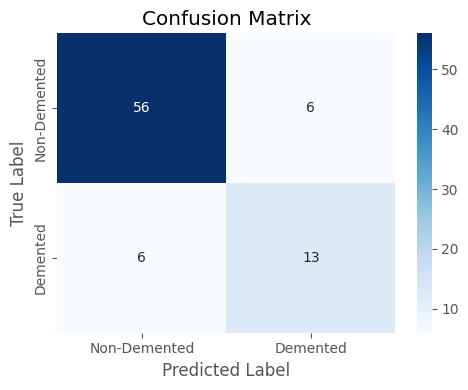

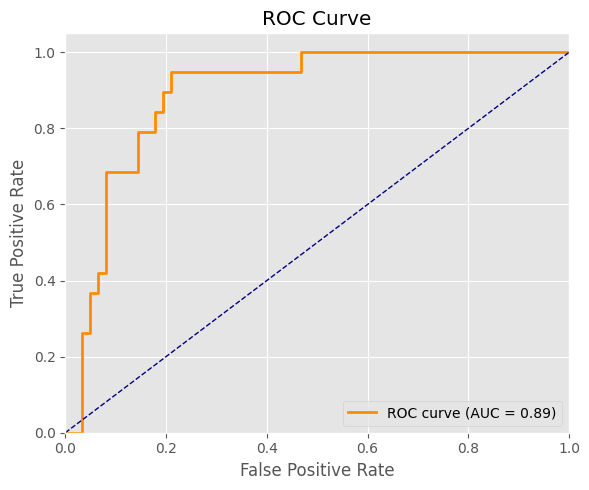

In [ ]:
# Predict on the test set
y_test_pred = model.predict(X_test_flat)
y_test_proba = model.predict_proba(X_test_flat)[:, 1]  # Probabilities for class 1 (Demented)

# Print header
print("FINAL SVM MODEL EVALUATION ON TEST SET")

# Evaluate and visualize
evaluate_model(
    y_true=y_test,
    y_pred=y_test_pred,
    y_proba=y_test_proba,
    class_names=['Non-Demented', 'Demented'])

# Save the confusion matrix
plt.savefig("confusion_matrix_svm_default_threshold.png", dpi=300)
plt.close()



EVALUATION WITH OPTIMAL THRESHOLD (0.2093)

Binary Classification Evaluation
Accuracy:             0.8272
Balanced Accuracy:    0.8688
Precision:            0.5806
Recall (Sensitivity): 0.9474
F1 Score:             0.7200
Log Loss:             0.3910
Brier Score:          0.1203
AUC-ROC:              0.8913

Classification Report:
              precision    recall  f1-score   support

Non-Demented       0.98      0.79      0.88        62
    Demented       0.58      0.95      0.72        19

    accuracy                           0.83        81
   macro avg       0.78      0.87      0.80        81
weighted avg       0.89      0.83      0.84        81



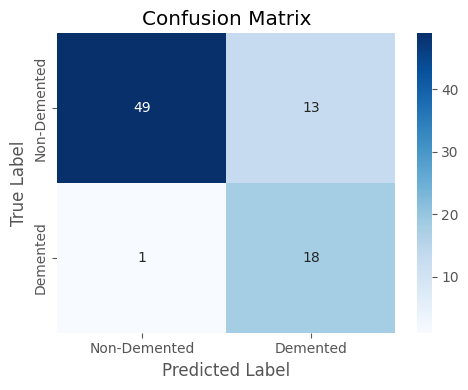

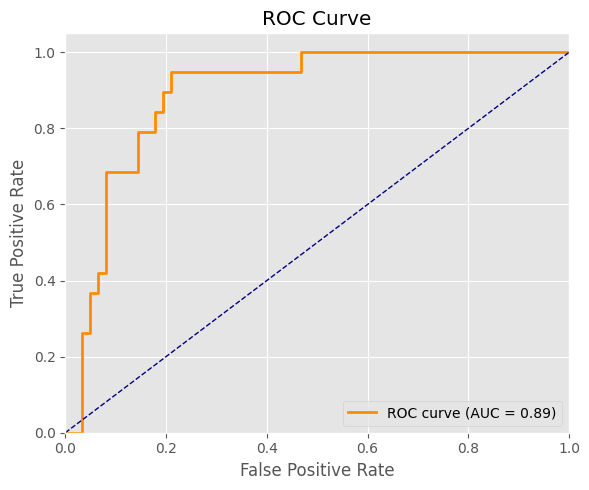

In [ ]:
from sklearn.metrics import precision_recall_curve
import numpy as np

# Get the predicted probabilities for the positive class (Demented)
y_test_proba = model.predict_proba(X_test_flat)[:, 1]

# Compute the optimal threshold based on F1 score
precision_vals, recall_vals, thresholds = precision_recall_curve(y_test, y_test_proba)
f1_scores = 2 * (precision_vals * recall_vals) / (precision_vals + recall_vals + 1e-8)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]

print(f"\nEVALUATION WITH OPTIMAL THRESHOLD ({optimal_threshold:.4f})")

# Convert probabilities to binary predictions based on optimal threshold
y_test_pred_optimal = (y_test_proba >= optimal_threshold).astype(int)

# Evaluate model performance with optimal threshold
evaluate_model(
    y_true=y_test,
    y_pred=y_test_pred_optimal,
    y_proba=y_test_proba,
    class_names=['Non-Demented', 'Demented'])

# Save the confusion matrix
plt.savefig("confusion_matrix_svm_optimal_threshold.png", dpi=300)
plt.close()
